In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

# Connecting to Data Folder.
%cd /content/drive/MyDrive/AMS559_Smart_Energy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AMS559_Smart_Energy


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load the CSV file
data = pd.read_csv('submission_file1.csv')

# Starting timestamp
start_time = datetime(2020, 12, 1, 12, 0)  # 12 PM December 1st, 2020

# Generate connectionHour column
data['connectionHour'] = [start_time + timedelta(hours=i) for i in range(len(data))]

# Filter out January data
data = data[data['connectionHour'] < datetime(2021, 1, 1)]

data_renamed = data.rename(columns={'Predicted': 'kWhDelivered', 'connectionHour': 'connectionHour'})

# Reorder the columns
data_reordered = data_renamed[['connectionHour', 'kWhDelivered']]

# Display the first 5 rows of the reordered dataset
data_reordered

,connectionHour,kWhDelivered
0,2020-12-01 12:00:00,6.680
1,2020-12-01 13:00:00,6.297
2,2020-12-01 14:00:00,5.953
3,2020-12-01 15:00:00,5.644
4,2020-12-01 16:00:00,5.369
...,...,...
727,2020-12-31 19:00:00,3.392
728,2020-12-31 20:00:00,3.392
729,2020-12-31 21:00:00,3.392
730,2020-12-31 22:00:00,3.392


In [ ]:
date_column_name = 'connectionTime'
train_data = pd.read_csv('train.csv')
train_data[date_column_name] = pd.to_datetime(train_data[date_column_name])
nov_dec_train_data = train_data[train_data[date_column_name].dt.month.isin([11, 12])]

# Convert relevant columns to datetime format
nov_dec_train_data['doneChargingTime'] = nov_dec_train_data['doneChargingTime'].fillna(nov_dec_train_data['disconnectTime'])
time_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']
for col in time_columns:
    nov_dec_train_data[col] = pd.to_datetime(nov_dec_train_data[col], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')


# Round down connectionTime to the nearest hour
nov_dec_train_data['connectionHour'] = nov_dec_train_data['connectionTime'].dt.floor('H')
nov_dec_train_data['doneChargingHour'] = nov_dec_train_data['doneChargingTime'].dt.floor('H')
nov_dec_train_data['disconnectChargingHour'] = nov_dec_train_data['disconnectTime'].dt.floor('H')


<ipython-input-16-c0f1afd2efc5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nov_dec_train_data['doneChargingTime'] = nov_dec_train_data['doneChargingTime'].fillna(nov_dec_train_data['disconnectTime'])
<ipython-input-16-c0f1afd2efc5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nov_dec_train_data[col] = pd.to_datetime(nov_dec_train_data[col], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
<ipython-input-16-c0f1afd2efc5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
def expand_and_distribute(row):
    start_hour = pd.to_datetime(row['connectionHour'])
    end_hour = pd.to_datetime(row['disconnectChargingHour'])
    kwh = row['kWhDelivered']

    # Generate all hours between start and end
    all_hours = pd.date_range(start=start_hour, end=end_hour, freq='H', inclusive='left')

    # Calculate kWh delivered per hour
    hours_count = len(all_hours)
    kwh_per_hour = kwh / hours_count if hours_count else 0

    # Create a DataFrame for each hour in the range
    hourly_data = pd.DataFrame({
        'connectionHour': all_hours,
        'disconnectChargingHour': end_hour,
        'kWhDelivered': kwh_per_hour
    })

    return hourly_data

# Apply the function to each row and concatenate the results
expanded_data = pd.concat([expand_and_distribute(row) for _, row in nov_dec_train_data.iterrows()], ignore_index=True)
# Group by the rounded connectionHour and aggregate kWhDelivered
kwh_per_hour = expanded_data.groupby('connectionHour')['kWhDelivered'].sum().reset_index()

In [ ]:
# Create a complete range of hourly timestamps
time_range = pd.date_range(start='2020-11-01 00:00:00',
                           end='2020-12-01 11:00:00',
                           freq='H')

# Create a DataFrame from the complete time range
complete_time_df = pd.DataFrame(time_range, columns=['connectionHour'])

# Merge with the aggregated data to identify missing hours
merged_data = pd.merge(complete_time_df, kwh_per_hour, on='connectionHour', how='left')

# Check for missing values, indicating missing hours
missing_hours = merged_data[merged_data['kWhDelivered'].isnull()]

# Display missing hours, if any
missing_hours

,connectionHour,kWhDelivered
0,2020-11-01 00:00:00,NaN
1,2020-11-01 01:00:00,NaN
2,2020-11-01 02:00:00,NaN
3,2020-11-01 03:00:00,NaN
4,2020-11-01 04:00:00,NaN
...,...,...
727,2020-12-01 07:00:00,NaN
728,2020-12-01 08:00:00,NaN
729,2020-12-01 09:00:00,NaN
730,2020-12-01 10:00:00,NaN


In [ ]:
#fill the missing values in 'kWhDelivered' column
merged_data['kWhDelivered'] = merged_data['kWhDelivered'].fillna(0)


In [ ]:
# Combine the datasets
final_dataset = pd.concat([merged_data, data_reordered], ignore_index=True)
final_dataset

,connectionHour,kWhDelivered
0,2020-11-01 00:00:00,0.000
1,2020-11-01 01:00:00,0.000
2,2020-11-01 02:00:00,0.000
3,2020-11-01 03:00:00,0.000
4,2020-11-01 04:00:00,0.000
...,...,...
1459,2020-12-31 19:00:00,3.392
1460,2020-12-31 20:00:00,3.392
1461,2020-12-31 21:00:00,3.392
1462,2020-12-31 22:00:00,3.392


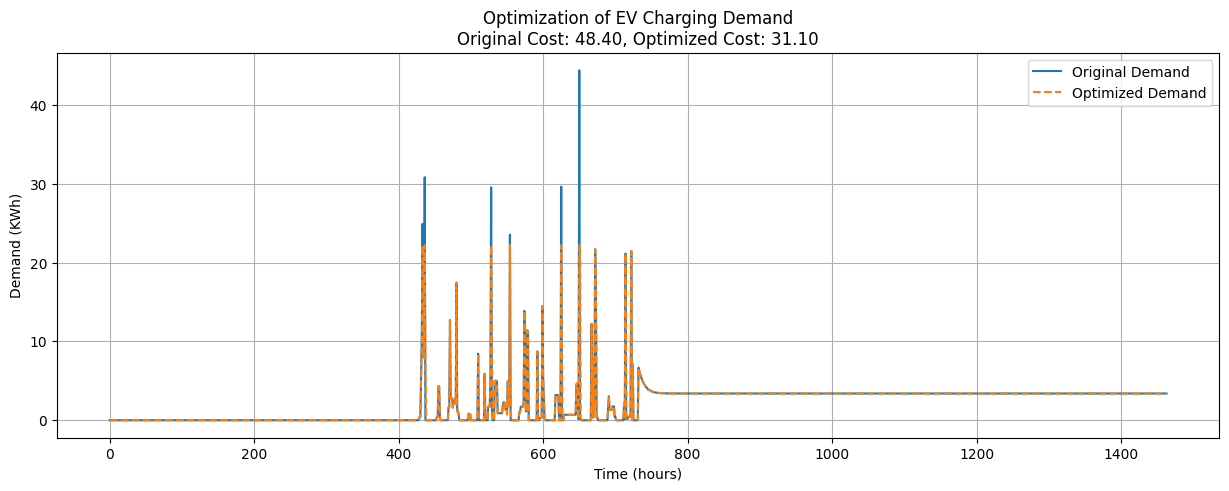

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Constants
alpha = 0.1

# Load data
P0 = final_dataset['kWhDelivered'].values  # Assuming the column for energy is 'KWhDelivered'

# Variables
D = cp.Variable(len(P0))  # Deferred energy

# Constraints
constraints = [D >= 0, D <= P0]  # Cannot defer more than available, no negative deferral
P = P0 - D + cp.hstack([0, D[:-1]])  # Shift D(t-1) to P(t)

# Cost function
P1 = cp.max(P[:720])
P2 = cp.max(P[745:1464])
objective = cp.Minimize(P1 + P2 + alpha * cp.sum(D))

problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimized deferred values and new demand profile
D_optimized = D.value
P_optimized = P0 - D_optimized + np.hstack([0, D_optimized[:-1]])

# Calculate costs for visualization
cost_original = max(P0[:720]) + max(P0[745:1464])
cost_optimized = max(P_optimized[:720]) + max(P_optimized[745:1464])
total_cost_optimized = max(P_optimized[:720]) + max(P_optimized[745:1464]) + alpha * sum(D_optimized)
# print(total_cost_optimized)

# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(P0, label='Original Demand')
plt.plot(P_optimized, label='Optimized Demand', linestyle='--')
plt.title(f'Optimization of EV Charging Demand\nOriginal Cost: {cost_original:.2f}, Optimized Cost: {total_cost_optimized:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('Demand (KWh)')
plt.legend()
plt.grid(True)
plt.show()


Alpha: 0.01, Optimized Cost: 26.46
Alpha: 0.05, Optimized Cost: 28.57
Alpha: 0.1, Optimized Cost: 31.10
Alpha: 0.2, Optimized Cost: 35.81
Alpha: 0.3, Optimized Cost: 38.37
Alpha: 0.5, Optimized Cost: 41.59
Alpha: 0.8, Optimized Cost: 45.68
Alpha: 1, Optimized Cost: 48.40
Alpha: 2, Optimized Cost: 48.40
Alpha: 3, Optimized Cost: 48.40
Alpha: 4, Optimized Cost: 48.40


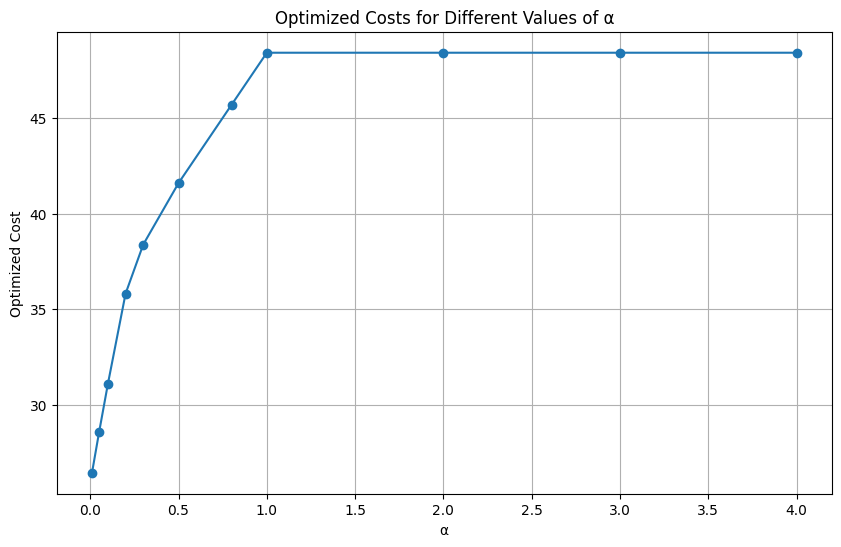

In [ ]:
# Function to run the optimization problem for different values of alpha
def run_optimization(alpha_values, P0):
    costs = []
    for alpha in alpha_values:
        # Define the optimization variables and parameters
        D = cp.Variable(len(P0))
        constraints = [D >= 0, D <= P0]
        P = P0 - D + cp.hstack([0, D[:-1]])

        # Define the cost function
        P1 = cp.max(P[:720])
        P2 = cp.max(P[745:1464])
        objective = cp.Minimize(P1 + P2 + alpha * cp.sum(D))

        # Define and solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # Store the results
        D_optimized = D.value
        P_optimized = P0 - D_optimized + np.hstack([0, D_optimized[:-1]])
        total_cost_optimized = max(P_optimized[:720]) + max(P_optimized[745:1464]) + alpha * sum(D_optimized)

        # Record the optimized cost for the current value of alpha
        costs.append((alpha, total_cost_optimized))

    return costs

# Sample P0 values, replace with actual data
P0 = final_dataset['kWhDelivered'].values

# Define the alpha values to test
alpha_values = [0.01, 0.05,0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 3, 4]

# Run the optimization for the defined alpha values
costs_for_different_alpha = run_optimization(alpha_values, P0)

# Print the results
for alpha, cost in costs_for_different_alpha:
    print(f"Alpha: {alpha}, Optimized Cost: {cost:.2f}")

# Plotting the results for different alphas
plt.figure(figsize=(10, 6))
alphas = [cost[0] for cost in costs_for_different_alpha]
optimized_costs = [cost[1] for cost in costs_for_different_alpha]
plt.plot(alphas, optimized_costs, marker='o')
plt.title('Optimized Costs for Different Values of α')
plt.xlabel('α')
plt.ylabel('Optimized Cost')
plt.grid(True)
plt.show()
